#### The perihelion precession of Mercury: An exploration of numerical simulations in Python
##### Amir Zarandi
First, I imported all the necessary libraries for the MBP. Once again, if you get errors executing the code, make sure you have ipympl installed through "conda install -c conda-forge ipympl". I don't have sliders but Matplot widgets makes interacting with plots easier.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.signal import argrelextrema
%matplotlib widget

Initializing all the constants needed. As explained in the write-up, Venus, Earth, and Jupiter play the biggest role in precession of mercury, thus I only included the data for those three. Since GM is used multiple times, I dedicated a variable to it as well. There's also a conversion factor from radians to arcsecs. All of these variables are initialized as double precision floating point numbers.

In [2]:
G = np.double(1.98227823e-29)           # Gravitational Constant
GM = np.double(1.98844e30) * G          # Standard Gravitational Parameter

# mass, eccentricity, and semimajor radius of orbit of Mercury, Venus, Earth, and Jupiter
m1 = np.double(3.30104e23);     m2 = np.double(4.86732e24);     m3 = np.double(5.97219e24);     m5 = np.double(1.89813e27)
e1 = np.double(0.20563593);     e2 = np.double(0.00677672);     e3 = np.double(0.01671123) ;    e5 = np.double(0.04838624)
a1 = np.double(0.387098261);    a2 = np.double(0.723333771);    a3 = np.double(1.00);           a5 = np.double(5.20287342)

rad = np.double(180 * 3600 / np.pi)     # conversion factor from radians to arcseconds

Lambda functions (small anonymous functions) for perihelion distance and velocity, used for initial conditions. 

In [3]:
xPeri = lambda a, e : a * (1 - e)
vPeri = lambda a, e: np.sqrt(GM * (1 + e) / xPeri(a, e))

Initial conditions for the motion of the planets we're interested in. We're assuming they all start at the perihelion. 

In [4]:
x1, x2, x3, x5 = xPeri(a1, e1), xPeri(a2, e2), xPeri(a3, e3), xPeri(a5, e5)
y1 = y2 = y3 = y5 = vx1 = vx2 = vx3 = vx5 = 0.0
vy1, vy2, vy3, vy5 = vPeri(a1, e1), vPeri(a2, e2), vPeri(a3, e3), vPeri(a5, e5)

Time array for numerically solving the differential equations. The number 120 guarantees roughly an integer number of jupiter orbits. This becomes important later on. Use 120000001 for a painfully slow running but more accurate code. In fact, the graphs for the write up were produced using 120000001 time steps. I didn't set it as default since someone using this code might want to see the results quickly. 

In [90]:
endTime = 120
times = np.linspace(0.0, endTime, 12000001) # or 120000001

Equations of motion for one planet solar system.

In [6]:
def planet1(x, t):
    # pos. vector   
    r1 = np.array([x[0], x[1]]) # Sun - planet
 
    # acc. [x, y]
    a1 = - GM / (np.linalg.norm(r1) ** 3) * r1
 
    # result array   
    dxdt = np.zeros(np.size(x))
    dxdt = [x[2], x[3], a1[0], a1[1]]
    return dxdt

Solve the differential equation:

In [7]:
ic1 = [x1, y1, vx1, vy1]
sol1 = odeint(planet1, ic1, times)

Plot the orbit of Mercury. 

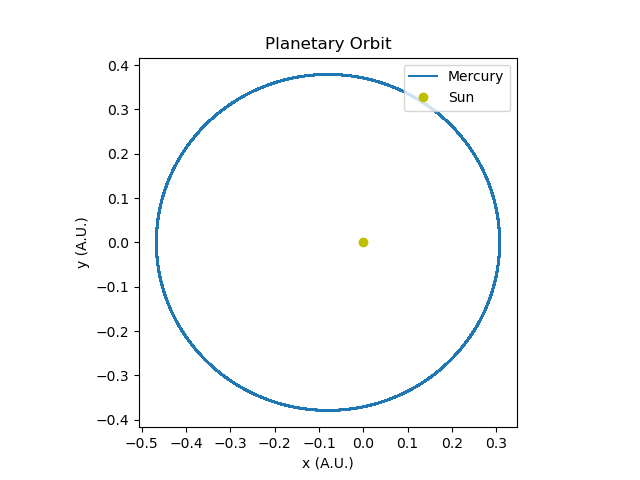

In [75]:
fig, ax = plt.subplots()
ax.set_aspect('equal', adjustable='box')

plt.plot(sol1[:,0], sol1[:,1], label = "Mercury")
plt.plot(0, 0, "yo", label = "Sun")
plt.legend(loc = 'upper right', numpoints = 1)
plt.xlabel("x (A.U.)")
plt.ylabel("y (A.U.)")
plt.title("Planetary Orbit")
plt.show()

Lambda functions for getting angle (in arcsecs) and angular distance given an array of Cartesian coordinates. Lambda function for getting the indices of all the local mins in an array. 

In [9]:
angle = lambda x : np.array([np.arctan(i[1]/i[0]) * rad for i in x])
distance = lambda x : np.array([np.linalg.norm([i[1], i[0]]) for i in x])

localMin = lambda x: argrelextrema(x, np.less)[0]

Perihelion finder. 

In [57]:
def perihelion(x):
    periIn = localMin(distance(x))      # identify local minima of distance from origin (Sun)
    peri = x[periIn]                    # reduce the given array to perihelions only
    peri = peri[:, [0, 1]]              # reduce the peri array to x and y coord only
    periAngle = angle(peri)             # get angles
    periDistance = distance(peri)       # get distances
    periTime = times[periIn]            # reduce the time array to perihelions only

    # return a 3-d array of times, angles, and distances
    return np.column_stack((periTime, periAngle, periDistance))

Find perihelions. SLOW RUNNING CODE AHEAD!!!

In [77]:
perihelion1 = perihelion(sol1)

Lambda function to get the slope of the best linear fit. 

In [82]:
bestFit = lambda x, y: np.polyfit(x, y, 1)[0]

Track the orientation of the perihelion over time and get the slope of the best fit line for this graph. This gives us precession in arsecs/year. 

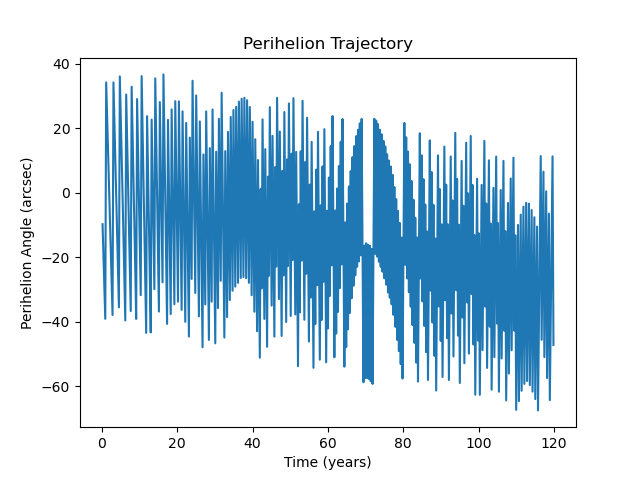

-0.24206924360537016


In [86]:
fig, ax = plt.subplots()
plt.plot(perihelion1[:, 0], perihelion1[:, 1])
plt.ylabel("Perihelion Angle (arcsec)")
plt.xlabel("Time (years)")
plt.title("Perihelion Trajectory")
plt.show()

print(bestFit(perihelion1[:, 0], perihelion1[:, 1]))

Plot the trajectory of the perihelion in polar coordinates.

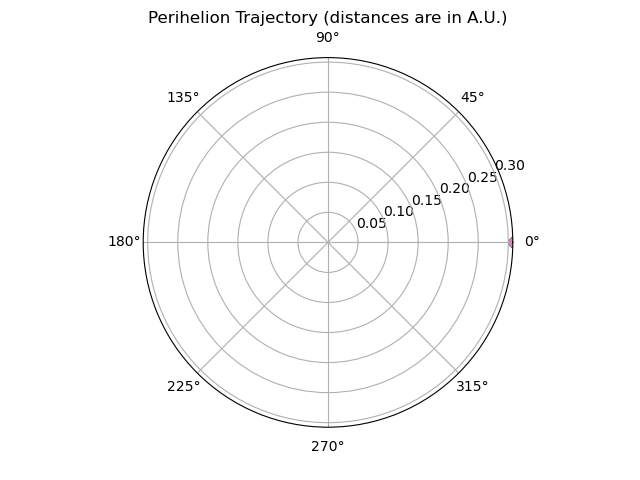

In [85]:
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
for peri in perihelion1:
    c = ax.scatter(peri[1] / rad, peri[2])
plt.title("Perihelion Trajectory (distances are in A.U.)")
plt.show()

Equations of motion for a two planet solar system.

In [14]:
def planet2(x, t, m1, m2):
    # pos. vectors   
    r1 = np.array([x[0], x[1]])     # Sun - planet 1
    r2 = np.array([x[4], x[5]])     # Sun - planet 2
    r12 = r2 - r1                   # planet 1 - planet 2
    r21 = - r12                     # planet 2 - planet 1
 
    # acc. [x,y]
    a1 = -(GM / (np.linalg.norm(r1) ** 3) * r1) - (G * m2 / (np.linalg.norm(r21) ** 3) * r21)
    a2 = -(GM / (np.linalg.norm(r2) ** 3) * r2) - (G * m1 / (np.linalg.norm(r12) ** 3) * r12)
 
    # result array   
    dxdt = np.zeros(np.size(x))
    dxdt = [x[2], x[3], a1[0], a1[1], x[6], x[7], a2[0], a2[1]]
    return dxdt

Solve differential equations for a Mercury + Venus Solar System.

In [15]:
ic2 = [x1, y1, vx1, vy1, x2, y2, vx2, vy2]
sol2 = odeint(planet2, ic2, times, args = (m1, m2))

Plot the orbit of Mercury. 

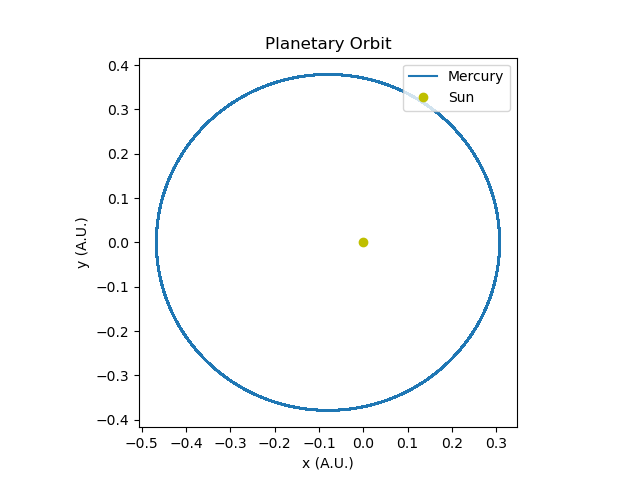

In [16]:
fig, ax = plt.subplots()
ax.set_aspect('equal', adjustable='box')

plt.plot(sol2[:,0], sol2[:,1], label = "Mercury")
#plt.plot(sol2[:,4], sol2[:,5], label = "Venus")

plt.plot(0, 0, "yo", label = "Sun")
plt.legend(loc = 'upper right', numpoints = 1)
plt.xlabel("x (A.U.)")
plt.ylabel("y (A.U.)")
plt.title("Planetary Orbit")
plt.show()

Find perihelions. SLOW RUNNING CODE AHEAD!!!

In [58]:
perihelion2 = perihelion(sol2)

Track the orientation of the perihelion over time and get the slope of the best fit line for this graph. 

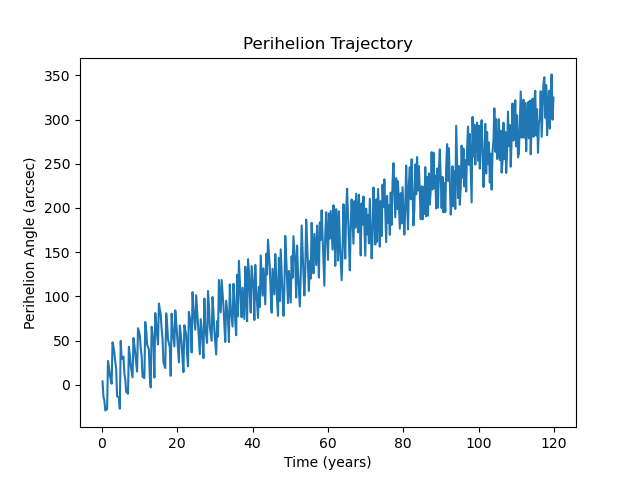

2.5895860105313098


In [59]:
fig, ax = plt.subplots()
plt.plot(perihelion2[:, 0], perihelion2[:, 1])
plt.ylabel("Perihelion Angle (arcsec)")
plt.xlabel("Time (years)")
plt.title("Perihelion Trajectory")
plt.show()

print(bestFit(perihelion2[:, 0], perihelion2[:, 1]))

Plot the trajectory of the perihelion in polar coordinates.

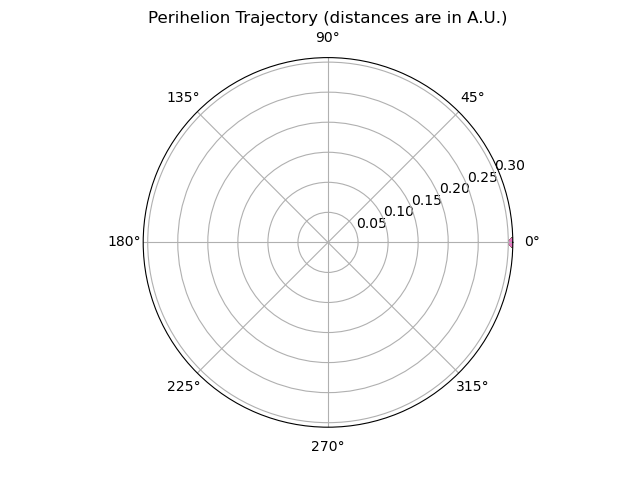

In [87]:
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
for peri in perihelion2:
    c = ax.scatter(peri[1] / rad, peri[2])
plt.title("Perihelion Trajectory (distances are in A.U.)")
plt.show()

Three planet system, you know the deal:

In [21]:
def planet3(x, t, m1, m2, m3):
    # pos. vectors   
    r1 = np.array([x[0], x[1]])     # Sun - planet 1
    r2 = np.array([x[4], x[5]])     # Sun - planet 2
    r3 = np.array([x[8], x[9]])     # Sun - planet 3
    r12 = r2 - r1                   # planet 1 - planet 2
    r21 = - r12                     # planet 2 - planet 1
    r13 = r3 - r1                   # planet 1 - planet 3
    r31 = - r13                     # planet 3 - planet 1
    r23 = r2 - r3                   # planet 2 - planet 3
    r32 = - r23                     # planet 3 - planet 2
 
    # acc. [x,y]
    a1 = -(GM / (np.linalg.norm(r1) ** 3) * r1) - (G * m2 / (np.linalg.norm(r21) ** 3) * r21) - (G * m3 / (np.linalg.norm(r31) ** 3) * r31)
    a2 = -(GM / (np.linalg.norm(r2) ** 3) * r2) - (G * m1 / (np.linalg.norm(r12) ** 3) * r12) - (G * m3 / (np.linalg.norm(r32) ** 3) * r32)
    a3 = -(GM / (np.linalg.norm(r3) ** 3) * r3) - (G * m1 / (np.linalg.norm(r13) ** 3) * r13) - (G * m2 / (np.linalg.norm(r23) ** 3) * r23)
 
    # result array   
    dxdt = np.zeros(np.size(x))
    dxdt = [x[2], x[3], a1[0], a1[1], x[6], x[7], a2[0], a2[1], x[10], x[11], a3[0], a3[1]]
    
    return dxdt

Mercury, Venus, and Earth. 

In [22]:
ic3 = [x1, y1, vx1, vy1, x2, y2, vx2, vy2, x3, y3, vx3, vy3]
sol3 = odeint(planet3, ic3, times, args = (m1, m2, m3))

Orbits:

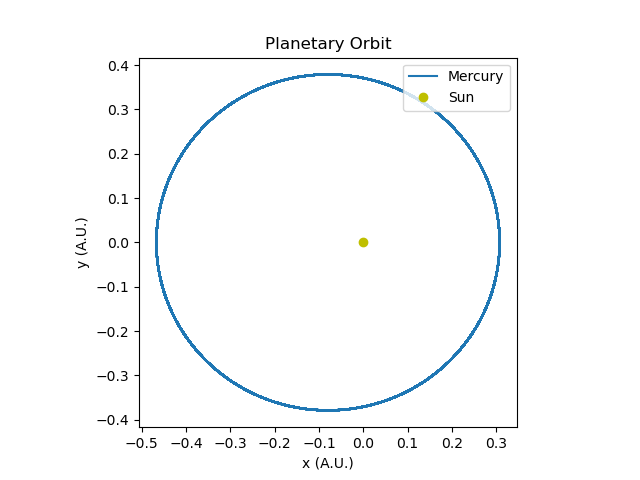

In [23]:
fig, ax = plt.subplots()
ax.set_aspect('equal', adjustable='box')

plt.plot(sol3[:,0], sol3[:,1], label = "Mercury")
#plt.plot(sol3[:,4], sol3[:,5], label = "Venus")
#plt.plot(sol3[:,8], sol3[:,9], label = "Earth")
plt.plot(0, 0, "yo", label = "Sun")
plt.legend(loc = 'upper right', numpoints = 1)
plt.xlabel("x (A.U.)")
plt.ylabel("y (A.U.)")
plt.title("Planetary Orbit")
plt.show()

Perihelions. SLOW RUNNING CODE AHEAD!!!

In [62]:
perihelion3 = perihelion(sol3)

Perihelion angle over time + best fit line slope. 

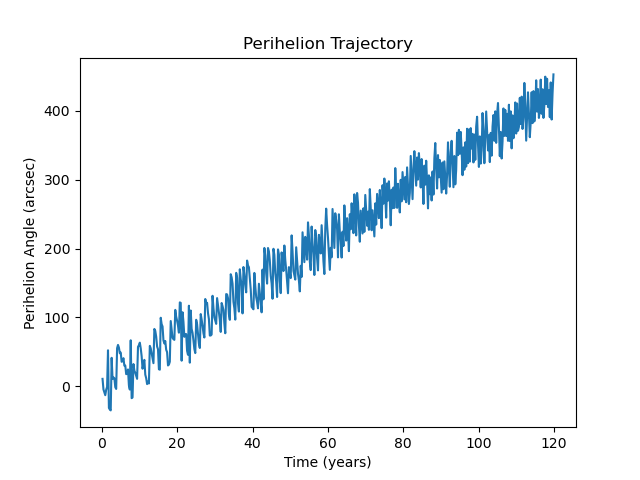

3.524809126911122


In [63]:
fig, ax = plt.subplots()
plt.plot(perihelion3[:, 0], perihelion3[:, 1])
plt.ylabel("Perihelion Angle (arcsec)")
plt.xlabel("Time (years)")
plt.title("Perihelion Trajectory")
plt.show()

print(bestFit(perihelion3[:, 0], perihelion3[:, 1]))

Polar Plot:

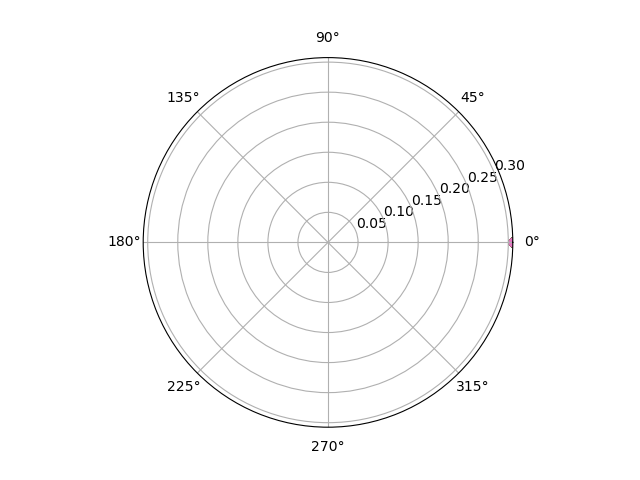

In [64]:
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
for peri in perihelion3:
    c = ax.scatter(peri[1] / rad, peri[2])
plt.title("Perihelion Trajectory (distances are in A.U.)")
plt.show()

Four Planets:

In [27]:
def planet4(x, t, m1, m2, m3, m4):
    # pos. vectors   
    r1 = np.array([x[0], x[1]])     # Sun - planet 1
    r2 = np.array([x[4], x[5]])     # Sun - planet 2
    r3 = np.array([x[8], x[9]])     # Sun - planet 3
    r4 = np.array([x[12], x[13]])   # Sun - planet 4
    r12 = r2 - r1                   # planet 1 - planet 2
    r21 = - r12                     # planet 2 - planet 1
    r13 = r3 - r1                   # planet 1 - planet 3
    r31 = - r13                     # planet 3 - planet 1
    r14 = r4 - r1                   # planet 1 - planet 4
    r41 = - r14                     # planet 4 - planet 1
    r23 = r2 - r3                   # planet 2 - planet 3
    r32 = - r23                     # planet 3 - planet 2
    r34 = r4 - r3                   # planet 3 - planet 4
    r43 = - r34                     # planet 4 - planet 3
    r24 = r4 - r2                   # planet 2 - planet 4
    r42 = - r24                     # planet 4 - planet 2
 
    # acc. [x,y]
    a1 = -(GM / (np.linalg.norm(r1) ** 3) * r1) - (G * m2 / (np.linalg.norm(r21) ** 3) * r21) - (G * m3 / (np.linalg.norm(r31) ** 3) * r31) - (G * m4 / (np.linalg.norm(r41) ** 3) * r41)
    a2 = -(GM / (np.linalg.norm(r2) ** 3) * r2) - (G * m1 / (np.linalg.norm(r12) ** 3) * r12) - (G * m3 / (np.linalg.norm(r32) ** 3) * r32) - (G * m4 / (np.linalg.norm(r42) ** 3) * r42)
    a3 = -(GM / (np.linalg.norm(r3) ** 3) * r3) - (G * m1 / (np.linalg.norm(r13) ** 3) * r13) - (G * m2 / (np.linalg.norm(r23) ** 3) * r23) - (G * m4 / (np.linalg.norm(r43) ** 3) * r43)
    a4 = -(GM / (np.linalg.norm(r4) ** 3) * r4) - (G * m1 / (np.linalg.norm(r14) ** 3) * r14) - (G * m2 / (np.linalg.norm(r24) ** 3) * r24) - (G * m3 / (np.linalg.norm(r34) ** 3) * r34)

    # result array   
    dxdt = np.zeros(np.size(x))
    dxdt = [x[2], x[3], a1[0], a1[1], x[6], x[7], a2[0], a2[1], x[10], x[11], a3[0], a3[1], x[14], x[15], a4[0], a4[1]]
    
    return dxdt

Solve ODEs for Venus, Earth, and Jupiter:

In [28]:
ic4 = [x1, y1, vx1, vy1, x2, y2, vx2, vy2, x5, y5, vx5, vy5, x3, y3, vx3, vy3]
sol4 = odeint(planet4, ic4, times, args = (m1, m2, m5, m3))

Plot the orbits:

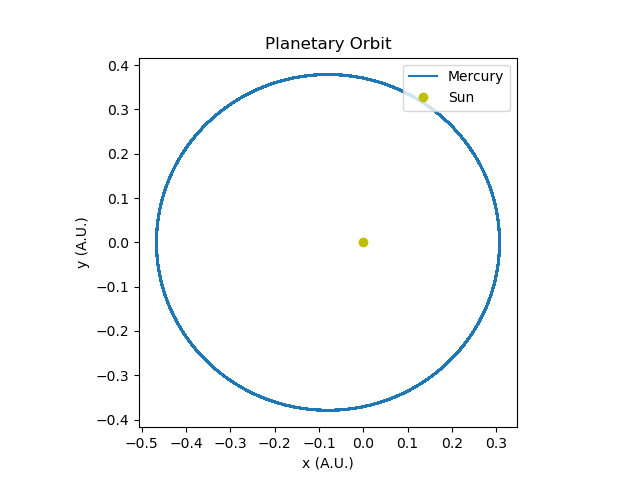

In [29]:
fig, ax = plt.subplots()
ax.set_aspect('equal', adjustable='box')

plt.plot(sol4[:,0], sol4[:,1], label = "Mercury")
#plt.plot(sol4[:,4], sol4[:,5], label = "Venus")
#plt.plot(sol4[:,12], sol4[:,13], label = "Earth")
#plt.plot(sol4[:,8], sol4[:,9], label = "Jupiter")

plt.plot(0, 0, "yo", label = "Sun")
plt.legend(loc = 'upper right', numpoints = 1)
plt.xlabel("x (A.U.)")
plt.ylabel("y (A.U.)")
plt.title("Planetary Orbit")
plt.show()

Perihelion. SLOW RUNNING CODE AHEAD!!!

In [65]:
perihelion4 = perihelion(sol4)

Angle versus time + best fit:

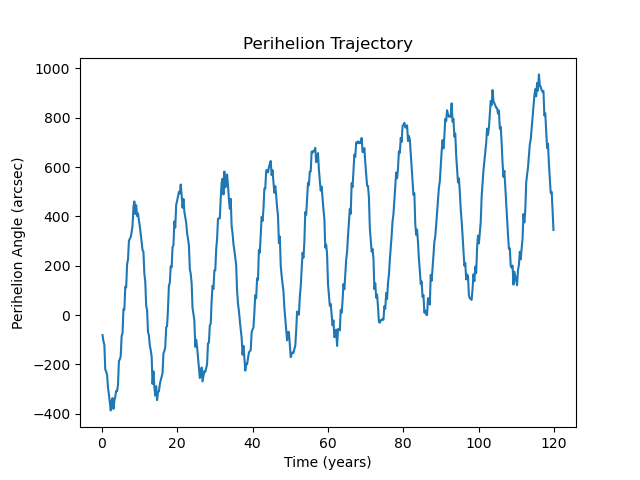

5.416469682444593


In [88]:
fig, ax = plt.subplots()
plt.plot(perihelion4[:, 0], perihelion4[:, 1])
plt.ylabel("Perihelion Angle (arcsec)")
plt.xlabel("Time (years)")
plt.title("Perihelion Trajectory")
plt.show()

print(bestFit(perihelion4[:, 0], perihelion4[:, 1]))

Polar:

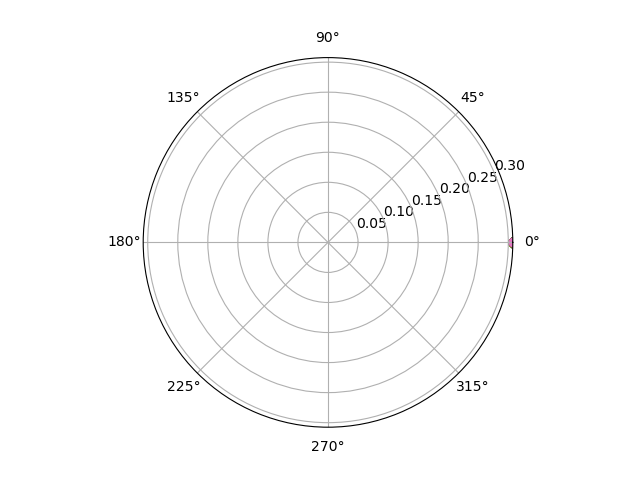

In [69]:
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
for peri in perihelion4:
    c = ax.scatter(peri[1] / rad, peri[2])
plt.title("Perihelion Trajectory (distances are in A.U.)")
plt.show()

Define Relativistic correction:

In [33]:
alpha = 1.1e-8

def correctedDistance(r):
    mag = np.linalg.norm(r)
    rel = 1 + alpha / (mag**2)
    return rel / (mag**3)

Four planets + correction:

In [34]:
def planet4R(x, t, m1, m2, m3, m4):
    # pos. vectors   
    r1 = np.array([x[0], x[1]])     # Sun - planet 1
    r2 = np.array([x[4], x[5]])     # Sun - planet 2
    r3 = np.array([x[8], x[9]])     # Sun - planet 3
    r4 = np.array([x[12], x[13]])   # Sun - planet 4
    r12 = r2 - r1                   # planet 1 - planet 2
    r21 = - r12                     # planet 2 - planet 1
    r13 = r3 - r1                   # planet 1 - planet 3
    r31 = - r13                     # planet 3 - planet 1
    r14 = r4 - r1                   # planet 1 - planet 4
    r41 = - r14                     # planet 4 - planet 1
    r23 = r2 - r3                   # planet 2 - planet 3
    r32 = - r23                     # planet 3 - planet 2
    r34 = r4 - r3                   # planet 3 - planet 4
    r43 = - r34                     # planet 4 - planet 3
    r24 = r4 - r2                   # planet 2 - planet 4
    r42 = - r24                     # planet 4 - planet 2
 
    # acc. [x,y]
    a1 = -(GM * correctedDistance(r1) * r1) - (G * m2 * correctedDistance(r21) * r21) - (G * m3 * correctedDistance(r31) * r31) - (G * m4 * correctedDistance(r41) * r41)
    a2 = -(GM * correctedDistance(r2) * r2) - (G * m1 * correctedDistance(r12) * r12) - (G * m3 * correctedDistance(r32) * r32) - (G * m4 * correctedDistance(r42) * r42)
    a3 = -(GM * correctedDistance(r3) * r3) - (G * m1 * correctedDistance(r13) * r13) - (G * m2 * correctedDistance(r23) * r23) - (G * m4 * correctedDistance(r43) * r43)
    a4 = -(GM * correctedDistance(r4) * r4) - (G * m1 * correctedDistance(r14) * r14) - (G * m2 * correctedDistance(r24) * r24) - (G * m3 * correctedDistance(r34) * r34)

    # result array   
    dxdt = np.zeros(np.size(x))
    dxdt = [x[2], x[3], a1[0], a1[1], x[6], x[7], a2[0], a2[1], x[10], x[11], a3[0], a3[1], x[14], x[15], a4[0], a4[1]]
    
    return dxdt

Find linear regression between alpha and precession. Use three example values of alpha and find the precessions. SUPER SLOW RUNNING CODE AHEAD!!!

In [71]:
alphaArr = [1e-9,1e-8, 1e-7]
periArr = []
for i in alphaArr:
    alpha = i
    sol4R = odeint(planet4R, ic4, times, args = (m1, m2, m5, m3))
    perihelion4R = perihelion(sol4R)
    periArr.append(bestFit(perihelion4R[:,0], perihelion4R[:,1]) * 100)

Plot the relationship.

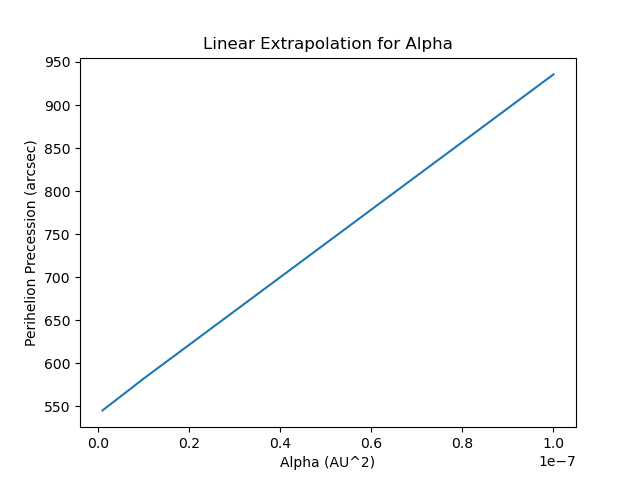

In [89]:
fig, ax = plt.subplots()
plt.plot(alphaArr, periArr)
plt.ylabel("Perihelion Precession (arcsec)")
plt.xlabel("Alpha (AU^2)")
plt.title("Linear Extrapolation for Alpha")
plt.show()

Use actual value of alpha to get the predicted precession. 

In [74]:
alpha =  1.1e-8

sol4R = odeint(planet4R, ic4, times, args = (m1, m2, m5, m3))

perihelion4R = perihelion(sol4R)

print(bestFit(perihelion4R[:,0], perihelion4R[:,1]))

5.8039072989362674
